In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sns
sns.color_palette("hls", 17)
import scipy.stats as st
import math

from pingouin import rcorr
import pingouin as pg

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn import svm 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc, roc_auc_score,precision_recall_curve,multilabel_confusion_matrix,hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import feature_selection #import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
import sys
import os

from sys import platform
if platform == "darwin":
    sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/..")
    smart_nlp_path = ''
elif platform == "win32":
    sys.path.append('../')
    smart_nlp_path = os.getcwd()
    smart_nlp_path = "\\".join([smart_nlp_path.split("\\")[i] for i in range(0,len(smart_nlp_path.split("\\"))-1)]+["/"])

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
test_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_full_test.csv')).drop(["Unnamed: 0"], axis=1)
train_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_full_train.csv')).drop(["Unnamed: 0"], axis=1)
val_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_full_val.csv')).drop(["Unnamed: 0"], axis=1)
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_summaryreps_full.csv')).drop(["Unnamed: 0"], axis=1)

C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7,13,18,19,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data

,INCIDENT_ID,INCIDENT_NUMBER,INCIDENT_NAME,INCTYP_ABBREVIATION,FINAL_ACRES,CAUSE,COMPLEX,DISCOVERY_DATE,DISCOVERY_DOY,EXPECTED_CONTAINMENT_DATE,...,Livestock,Law_Violations,Military_Base,Infrastructure,Extreme_Weather,Ecological,Hazardous_Terrain,Floods,Dry_Weather,Severity
0,2000_CA-RRU-062485_VALLEY COMPLEX,CA-RRU-062485,VALLEY COMPLEX,WF,1312.0,L,True,2010-07-15 15:00:00,196,2010-07-18 00:00:00,...,0,0,0,0,1,0,1,0,0,1
1,2005_OK-CHA-005077_WILLIS,OK-CHA-005077,WILLIS,WF,460.0,H,False,2005-12-30 00:00:00,1,2006-01-05 16:00:00,...,0,0,0,0,0,0,0,0,0,1
2,2006_00276_MILLER COMPLEX,00276,MILLER COMPLEX,WF,300.0,L,True,2006-06-26 19:55:00,177,2006-07-03 18:00:00,...,0,0,0,0,0,1,0,0,0,0
3,2006_1224_MULTIPLE JUNE FIRES,1224,MULTIPLE JUNE FIRES,WF,21.0,L,False,2006-06-26 15:00:00,177,2006-07-01 18:00:00,...,0,0,0,0,0,0,1,0,0,0
4,2006_AK-DAS-612166_JARVIS CREEK,AK-DAS-612166,JARVIS CREEK,WF,275.0,H,False,2006-06-08 11:13:00,159,2006-06-13 23:59:00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,2014_VAS1400656_SANDY RIDGE,VAS1400656,Sandy Ridge,WF,600.0,H,False,2014-04-20 17:00:00,110,NaN,...,0,0,0,0,0,0,0,0,0,0
8969,2014_VAS1406056_HUNTERS VALLEY WEST,VAS1406056,Hunters Valley West,WF,80.0,H,False,2014-04-19 08:00:00,109,NaN,...,0,0,0,0,0,0,0,0,0,0
8970,2014_VAVAS1403037_BEAVER LODGE RD.,VAVAS1403037,Beaver Lodge Rd.,WF,0.0,H,False,2014-03-15 14:30:00,74,NaN,...,0,0,0,0,0,0,0,0,0,2
8971,2014_VAVAS1406037_AIRPORT MOUNTAIN,VAVAS1406037,Airport Mountain,WF,200.0,H,False,2014-03-19 14:00:00,78,NaN,...,0,0,0,0,0,0,0,0,0,0


In [5]:
predictors = ["TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED",
              "ACRES",  "WF_FSR", "INJURIES", "FATALITIES", "EST_IM_COST_TO_DATE", "STR_DAMAGED",
              "STR_DESTROYED", "NEW_ACRES", "EVACUATION_IN_PROGRESS", 
              "NUM_REPORTS", "DAYS_BURING", 'Combined_Text', 'Incident_region_AICC', 
              'Incident_region_CA', 'Incident_region_EACC','Incident_region_GBCC', 'Incident_region_HICC', 
              'Incident_region_NRCC','Incident_region_NWCC', 'Incident_region_RMCC', 'Incident_region_SACC',
              'Incident_region_SWCC', 'INC_MGMT_ORG_ABBREV_1', 'INC_MGMT_ORG_ABBREV_2','INC_MGMT_ORG_ABBREV_3', 
              'INC_MGMT_ORG_ABBREV_4','INC_MGMT_ORG_ABBREV_5', 'INC_MGMT_ORG_ABBREV_B','INC_MGMT_ORG_ABBREV_C', 
              'INC_MGMT_ORG_ABBREV_D','INC_MGMT_ORG_ABBREV_E', 'INC_MGMT_ORG_ABBREV_F']
targets = ["Traffic","Command_Transitions","Evacuations", "Inaccurate_Mapping", "Aerial_Grounding", 
           "Resource_Issues", "Injuries", "Cultural_Resources","Livestock", "Law_Violations", "Military_Base", 
           "Infrastructure", "Extreme_Weather", "Ecological", "Hazardous_Terrain", "Floods", "Dry_Weather"]

In [6]:
data.columns

Index(['INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FINAL_REPORT_DATE', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'STR_THREATENED_MAX', 'STR_THREATENED_COMM_MAX',
       'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM', 'TOTAL_PERSONNEL_SUM',
       'WF_PEAK_AERIAL', 'WF_PEAK_AERIAL_DATE', 'WF_PEAK_AERIAL_DOY',
       'WF_PEAK_PERSONNEL', 'WF_

C:\Users\srandrad\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


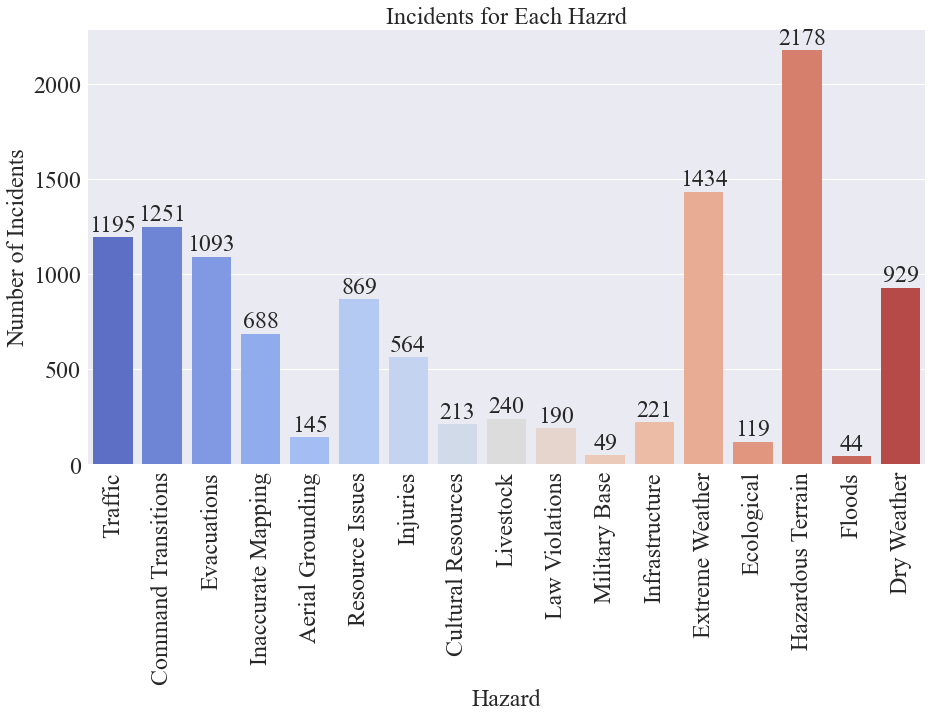

In [23]:
categories = [t.replace("_"," ") for t in targets]
counts = list(data.iloc[:,68:85].sum().values)
colors = cm.coolwarm(np.linspace(0, 1, len(categories)))
#sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, counts, palette="coolwarm")#colors=colors)
plt.title("Incidents for Each Hazrd", fontsize=24)
plt.ylabel('Number of Incidents', fontsize=24)
plt.xlabel('Hazard', fontsize=24)
ax.set_xticklabels(categories, rotation='vertical', fontsize=24)
for label in ax.get_yticklabels():
    label.set_fontsize(24)
#ax.set_xticklabels(fontsize=18)
#adding the text labels
rects = ax.patches
labels = data.iloc[:,68:85].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=24)
plt.savefig('incidents_per_hazard.pdf', bbox_inches="tight")
plt.show()


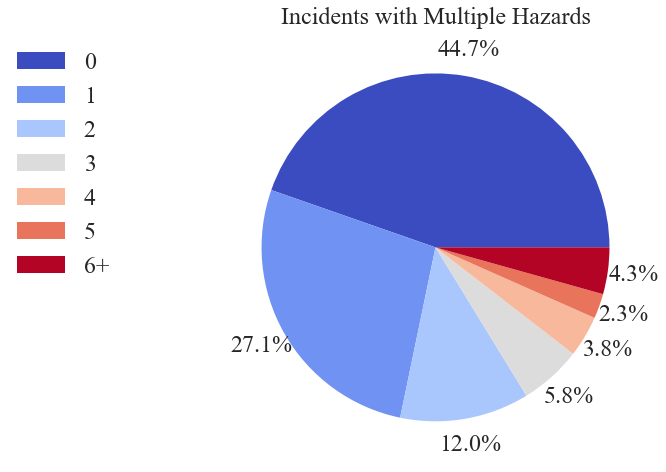

In [24]:
rowSums = data.iloc[:,68:85].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[0:]
multiLabel_counts_grouped = multiLabel_counts.iloc[0:6]
multiLabel_counts_grouped.at[6] = sum(multiLabel_counts.iloc[6:]) 
labels = [ind for ind in multiLabel_counts_grouped.index]
labels[-1] = str(labels[-1])+"+"
plt.figure(figsize=(15,8))
colors = cm.coolwarm(np.linspace(0, 1, len(labels)))
plt.pie(multiLabel_counts_grouped.values, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 24},labeldistance=None, pctdistance=1.15)
plt.title("Incidents with Multiple Hazards",fontsize=24)
plt.legend(bbox_to_anchor=(-0.2, 1),fontsize=24)
plt.savefig('incidents_with_multiple_hazards.pdf',bbox_inches="tight") 
plt.show()
